<a href="https://colab.research.google.com/github/aswini8989/facemask_detection_yolo/blob/main/facemask_detection_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone YOLOv5 repo
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Install dependencies
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17516 (delta 7), reused 0 (delta 0), pack-reused 17496 (from 4)
Receiving objects: 100% (17516/17516), 16.60 MiB | 20.00 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Unzip the dataset
!unzip /content/drive/MyDrive/mask_dataset -d /content/mask_dataset


unzip:  cannot find or open /content/drive/MyDrive/mask_dataset, /content/drive/MyDrive/mask_dataset.zip or /content/drive/MyDrive/mask_dataset.ZIP.


In [4]:
data_yaml = """
train: /content/mask_dataset/images/train
val: /content/mask_dataset/images/val

nc: 2
names: ['no_mask', 'mask']
"""

with open("mask_data.yaml", "w") as f:
    f.write(data_yaml)


In [5]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17516 (delta 7), reused 0 (delta 0), pack-reused 17496 (from 4)
Receiving objects: 100% (17516/17516), 16.60 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.
/content/yolov5/yolov5


In [6]:
import os
os.environ['WANDB_MODE'] = 'disabled'


In [8]:
data_yaml = """
train: /content/mask_dataset/images/train
val: /content/mask_dataset/images/val

nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']
"""

with open("/content/mask_data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ mask_data.yaml created at /content/mask_data.yaml")


✅ mask_data.yaml created at /content/mask_data.yaml


In [9]:
!cat /content/mask_data.yaml



train: /content/mask_dataset/images/train
val: /content/mask_dataset/images/val

nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']


In [14]:
ANNOTATIONS_DIR = '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/annotations'


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
import xml.etree.ElementTree as ET

# ✅ UPDATE THIS: Your real path inside Drive
ANNOTATIONS_DIR = '/content/drive/MyDrive/mask_dataset/annotations'
YOLO_LABELS_DIR = '/content/drive/MyDrive/mask_dataset/labels/train'
os.makedirs(YOLO_LABELS_DIR, exist_ok=True)

class_map = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}

def convert_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

for filename in os.listdir(ANNOTATIONS_DIR):
    if not filename.endswith(".xml"):
        continue
    tree = ET.parse(os.path.join(ANNOTATIONS_DIR, filename))
    root = tree.getroot()
    image_id = root.find('filename').text.replace(".png", "")

    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    yolo_txt = ""

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in class_map:
            continue
        cls_id = class_map[label]
        xml_box = obj.find('bndbox')
        box = (
            int(xml_box.find('xmin').text),
            int(xml_box.find('xmax').text),
            int(xml_box.find('ymin').text),
            int(xml_box.find('ymax').text)
        )
        bbox = convert_to_yolo((w, h), box)
        yolo_txt += f"{cls_id} {' '.join(format(x, '.6f') for x in bbox)}\n"

    with open(os.path.join(YOLO_LABELS_DIR, image_id + ".txt"), "w") as f:
        f.write(yolo_txt)

print("✅ All annotations converted to YOLO format in:", YOLO_LABELS_DIR)


✅ All annotations converted to YOLO format in: /content/drive/MyDrive/mask_dataset/labels/train


In [20]:
import os
import shutil
from glob import glob
from sklearn.model_selection import train_test_split

# Paths
BASE_DIR = "/content/drive/MyDrive/mask_dataset"
image_dir = os.path.join(BASE_DIR, "images")
label_dir = os.path.join(BASE_DIR, "labels/train")

# Load all image paths
all_images = glob(os.path.join(image_dir, "*.png"))

# 80/20 split
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

# Create split folders
for split in ["train", "val"]:
    os.makedirs(os.path.join(BASE_DIR, f"images/{split}"), exist_ok=True)
    os.makedirs(os.path.join(BASE_DIR, f"labels/{split}"), exist_ok=True)

# Move files only if src ≠ dst
def move_files(img_list, split):
    for img_path in img_list:
        filename = os.path.basename(img_path)
        label_path = os.path.join(label_dir, filename.replace(".png", ".txt"))

        dest_img = os.path.join(BASE_DIR, f"images/{split}", filename)
        dest_label = os.path.join(BASE_DIR, f"labels/{split}", filename.replace(".png", ".txt"))

        if img_path != dest_img:
            shutil.copy(img_path, dest_img)
        if os.path.exists(label_path) and label_path != dest_label:
            shutil.copy(label_path, dest_label)

move_files(train_imgs, "train")
move_files(val_imgs, "val")

print("✅ No duplicates. Train/val split is now clean and complete.")


✅ No duplicates. Train/val split is now clean and complete.


In [21]:
!ls /content/drive/MyDrive/mask_dataset/images/train | wc -l
!ls /content/drive/MyDrive/mask_dataset/images/val | wc -l


690
173


In [24]:
# Clone Ultralytics YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17516 (delta 7), reused 0 (delta 0), pack-reused 17496 (from 4)
Receiving objects: 100% (17516/17516), 16.60 MiB | 20.31 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.
/content/yolov5/yolov5/yolov5


In [26]:
!ls -l /content/drive/MyDrive/mask_dataset/


total 12
drwx------ 2 root root 4096 Jul 24 06:59 annotations
drwx------ 4 root root 4096 Jul 24 09:17 images
drwx------ 4 root root 4096 Jul 24 09:17 labels


In [27]:
yaml_path = "/content/drive/MyDrive/mask_dataset/mask_data.yaml"

yaml_content = """
train: /content/drive/MyDrive/mask_dataset/images/train
val: /content/drive/MyDrive/mask_dataset/images/val

nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content.strip())

print("✅ mask_data.yaml created at:", yaml_path)


✅ mask_data.yaml created at: /content/drive/MyDrive/mask_dataset/mask_data.yaml


In [28]:
!cat /content/drive/MyDrive/mask_dataset/mask_data.yaml


train: /content/drive/MyDrive/mask_dataset/images/train
val: /content/drive/MyDrive/mask_dataset/images/val

nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [32]:
!python train.py \
  --img 416 \
  --batch 16 \
  --epochs 10 \
  --data /content/drive/MyDrive/mask_dataset/mask_data.yaml \
  --weights yolov5s.pt \
  --name facemask_detector_yolo


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-07-24 11:05:10.844455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753355110.877845   34002 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753355110.887459   34002 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/mask_dataset/mask_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_popul

In [33]:
from google.colab import files
uploaded = files.upload()


Saving aswini pof.jpg to aswini pof.jpg


In [35]:
!python detect.py \
  --weights runs/train/facemask_detector_yolo/weights/best.pt \
  --imgsz 416 \
  --conf-thres 0.25 \
  --source "aswini pof.jpg"


detect: weights=['runs/train/facemask_detector_yolo/weights/best.pt'], source=aswini pof.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/yolov5/yolov5/aswini pof.jpg: 416x416 1 without_mask, 243.0ms
Speed: 1.9ms pre-process, 243.0ms inference, 4.0ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp


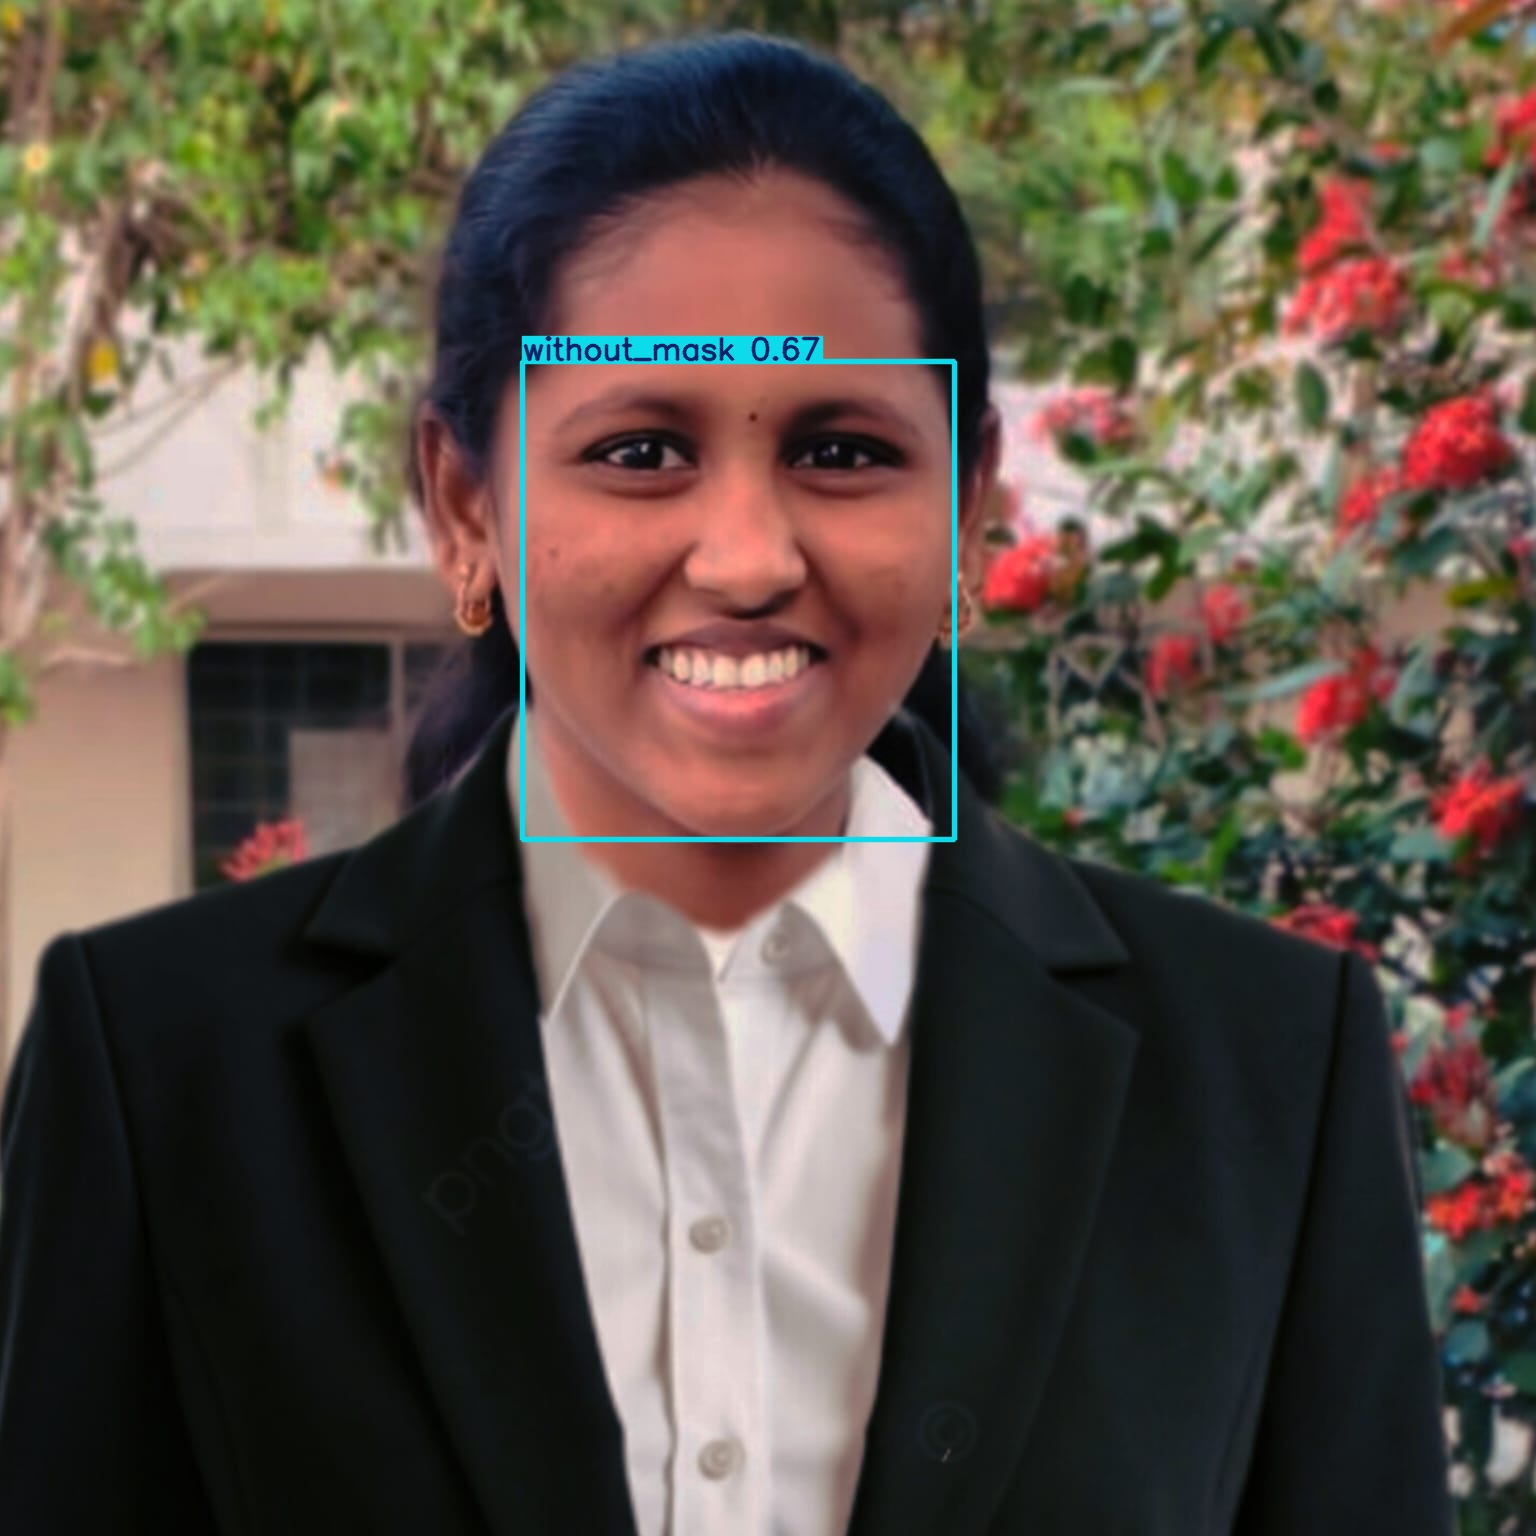

In [37]:
from IPython.display import Image, display
display(Image(filename='runs/detect/exp/aswini pof.jpg', width=600))



In [38]:
!cp "runs/detect/exp/aswini pof.jpg" /content/drive/MyDrive/


In [41]:
!zip -r facemask_detection_dl.zip /content/yolov5


  adding: content/yolov5/ (stored 0%)
  adding: content/yolov5/README.md (deflated 78%)
  adding: content/yolov5/classify/ (stored 0%)
  adding: content/yolov5/classify/val.py (deflated 65%)
  adding: content/yolov5/classify/predict.py (deflated 68%)
  adding: content/yolov5/classify/train.py (deflated 65%)
  adding: content/yolov5/classify/tutorial.ipynb (deflated 80%)
  adding: content/yolov5/CITATION.cff (deflated 31%)
  adding: content/yolov5/LICENSE (deflated 66%)
  adding: content/yolov5/val.py (deflated 70%)
  adding: content/yolov5/train.py (deflated 71%)
  adding: content/yolov5/README.zh-CN.md (deflated 76%)
  adding: content/yolov5/.git/ (stored 0%)
  adding: content/yolov5/.git/description (deflated 14%)
  adding: content/yolov5/.git/refs/ (stored 0%)
  adding: content/yolov5/.git/refs/remotes/ (stored 0%)
  adding: content/yolov5/.git/refs/remotes/origin/ (stored 0%)
  adding: content/yolov5/.git/refs/remotes/origin/HEAD (stored 0%)
  adding: content/yolov5/.git/refs/tags/

In [42]:
from google.colab import files
files.download("facemask_detection_dl.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>